# New Pipeline

## Setup

In [28]:
%%capture
#!pip install google-colab
!pip install sentence_transformers
#!pip install setfit
!pip install imblearn
!pip install rapidfuzz
!pip install seaborn

In [3]:
# if in colab
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
import spacy
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, cohen_kappa_score
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import os
import json
import time
#import cupy as cp
import random
import seaborn
#r = random.Random(9)
#random.seed(9)

In [3]:
cwd = os.getcwd()
print(cwd)

# if in colab
#os.listdir(cwd+"/drive/MyDrive/PhD/CoLabs")
input_path = cwd+"/drive/MyDrive/PhD/CoLabs/admin.json"
output_dir =  cwd+"/drive/MyDrive/PhD/CoLabs/"
full_inp_path = cwd+"/drive/MyDrive/PhD/CoLabs/ForestLablTmp_prelab.json"

# if on laptop
output_dir =  cwd+"../../outputs"
input_dir =  cwd+"../../inputs"
#input_path = cwd+"/../../../../Downloads/admin.json"
#input_path = input_dir+"/01Nov2024_first_dataset.json"
#full_inp_path = cwd+"/../../policy-classifier/populate_corpora/outputs/ForestLablTmp_prelab.json"

c:\Users\allie\Documents\GitHub\policy-classifier\classifier


## Function Definitions

### Data Preparation

In [ ]:
def dcno_to_sentlab(dcno_json):
    sents = []
    labels = []
    for entry in dcno_json:
        if entry["label"] != []:
            if entry["label"][0].lower() !="unsure":
                sents.append(entry["text"])
                labels.append(entry["label"][0])
    print(f'Sanity Check: {len(sents)} sentences and {len(labels)} labels')
    return sents, labels

def gen_bn_lists(sents, labels):
  '''
  This gets the lists of the sentences for the binary classification: one list of incentives, one of non-incentives.
  inputs:
  sents - list of sentences
  labels - labels
  returns:
  inc - incentive sentences
  noninc - nonincentive sentences
  '''
  inc =[]
  noninc =[]

  for sent, label in zip(sents, labels):
    if label.lower() == "non-incentive":
      noninc.append(sent)
    else:
      inc.append(sent)
  print(f'Sanity Check: {len(inc)} incentive sentences and {len(noninc)} non-incentive sentences')
  return inc, noninc

def gen_mc_sentlab(sents, labels):
  '''
  This fxn takes the list of sentences and the labels aggregated in the different methods
  and returns the incentive-specific sentences
  inputs:
  sents - list of sentences
  labels - labels
  outputs:
  sents - classified incentive sentences
  labs - classified incentive labels
  '''
  mc_sents = []
  mc_labels = []

  for sent, label in zip(sents, labels):
    if label.lower() == "non-incentive":
      continue
    else:
      mc_sents.append(sent)
      mc_labels.append(label)

  print(f'Sanity Check: {len(mc_sents)} incentive sentences and {len(mc_labels)} incentive labels')
  return mc_sents, mc_labels

### Data Augmentation

In [5]:
# adapted from old repo
import json
import os
from os import listdir
from os.path import isfile, join
import random
import time
import csv
import sys
import argparse
from tqdm import tqdm
import textwrap

# Model libraries
from sentence_transformers import SentenceTransformer
import sentencepiece
from scipy.spatial import distance
import numpy as np

from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [6]:
QUERIES_DCT = {
  "This scheme gives farmers greater access to financial loans and encourages financial planning." : "Credit",
  "National initiatives, such as the Future Growth Loan Scheme, supports strategic long-term capital investment by providing competitively priced loan instruments under favourable terms." : "Credit",
  "Harvest and production insurance that contributes to safeguarding producers' incomes where there are losses as a consequence of natural disasters, adverse climatic events, diseases or pest infestations while ensuring that beneficiaries take necessary risk prevention measures." : "Credit",
  "The Department of Agriculture Food and the Marine has funded a number of loan schemes which provide access to finance for famers in Ireland, enabling them to maintain liquidity and ensure they can take investment decisions tailored to their enterprise" : "Credit",
  "In cases where a loan is used to finance or top up a mutual fund no distinction is made between the basic capital and loans taken out in respect of the replenishment of the fund following compensate to growers." : "Credit",
  "The Scheme is supporting generational renewal on Irish farms by allowing young farmers to avail of a higher grant rate of 60% (with a standard grant rate of 40% available to all other applicants)." : "Direct_payment",
  "This programme incorporated extra payments on top of the basic REPS premium for farmers who undertook additional environmentally friendly farming practices." : "Direct_payment",
  "Forestry Programme 2014 -2020 providing grants and / or annual premiums for establishment, development and reconstitution of forests, woodland improvement, native woodland conservation." : "Direct_payment",
  "In addition to providing a basic income support to primary producers and achieving a higher level of environmental ambition, Pillar I (direct payments) interventions are aimed at achieving a fairer approach to the distribution of payments in Ireland." : "Direct_payment",
  "Decision to set an amount of direct payments not higher than EUR 5 000 under which farmers shall in any event be considered as ‘active farmers.’" : "Direct_payment",
  "Landowners found burning illegally could face fines, imprisonment and Single Farm Payment penalties, where applicable." : "Fine",
  "In the absence of abatement strategies, ammonia emissions are forecast to increase which may result either in substantial fines or the imposition of a de-facto quota based on emission levels." : "Fine",
  "If an offence is committed by a public body, and is committed with the consent of, or is attributable to the neglect on the part of a director, manager or other officer of the public body, that person will also be liable for prosecution; on conviction, fines up to €250,000 or imprisonment for up to 2 years, or both, may be imposed 125 Per s ection 14A(6) of the Act." : "Fine",
  "In addition, a fine will apply which will be calculated on the difference between the area declared and the area determined." : "Fine",
  "Where trees have been—(a) felled or otherwise removed without a licence under section 7,(b) felled under a licence and, either at the time of such felling or subsequently, a condition of the licence is contravened, or(c) in the opinion of the Minister, seriously damaged, the Minister may issue a replanting order in respect of the owner requiring him or her to replant or to fulfil any or all of the conditions that attached to the licence (or, in a case in which no licence was granted, any or all of the conditions that would, in the opinion of the Minister, have been attached to a licence had such been granted) in accordance with the provisions of the orderSections 27-29 detail offences and corresponding penalties, from fixed penalties to (on conviction) substantial fines and imprisonment." : "Fine",
  "Similarly, the On-Farm Capital Investments Scheme has provisions for investments in equipment that will allow farmers to reduce the amount of Green House Gas emissions that they produce during their agricultural practices." : "Supplies",
  "The intervention also supports investments that allow farmers to acquire technologies and equipment that increases their efficiencies and climate adaptation potential thus addressing Obj4N4 and Obj4N5." : "Supplies",
  "Grants are provided for farmers wishing to invest in productive technologies and or equipment." : "Supplies",
  "Support provided under this scheme will directly address Obj5N1 and Obj5N2 by providing an incentive to farmers to invest in machinery and equipment that better protects air and water quality." : "Supplies",
  "The On Farm Capital Investment Scheme also addresses Obj9N1 by providing a higher grant rate of support for investments in organic farming materials/equipment, at a higher rate of 60% in comparison to the rate of 40% for general investments." : "Supplies",
  "To complement the EXEED programme, the tax code provides for accelerated capital allowances (ACAs) for energy efficient equipment supporting the reduction of energy use in the workplace and the awareness of energy efficiency standards in appliances." : "Tax_deduction",
  "A tax incentive for companies paying corporation tax is also in place in the form of accelerated capital allowance for energy efficient equipment." : "Tax_deduction",
  "The Accelerated Capital Allowance (ACA) is a tax credit that encourages the purchase of energy -efficient goods" : "Tax_deduction",
  "These include the granting of an enhanced 50% stock tax relief to members of registered farm partnerships; the recognition of such arrangements in the calculation of payments under the Pillar I and Pillar II Schemes; and the introduction of a Support for Collaborative Farming Grant Scheme for brand new farm partnerships." : "Tax_deduction",
  "We are committed to further developing a taxation framework, which plays its full part in incentivising, along with other available policy levers, the necessary actions to reduce our emissions" : "Tax_deduction",
  "The Knowledge Transfer (KT) initiative is a significant investment in high quality training and upskilling of farmers so that they are equipped to deal with the range of challenges and opportunities arising in the agri-food sector." : "Technical_assistance",
  "The associated training will educate farmers on how to appropriately implement the actions of the scheme; thereby equipping them with the knowledge and skills necessary to optimise delivery and continue the ongoing management of the commitments undertaken; as well as to facilitate the implementation of high welfare practices." : "Technical_assistance",
  "This scheme has two measures: • provides financial support towards the professional costs, such as legal, taxation and advisory, incurred during the establishment of a Registered Farm Partnership." : "Technical_assistance",
  "LEADER may provide support rates greater than 65% in accordance with Article 73(4) (c)(ii) where investments include basic services in rural areas and infrastructure in agriculture and forestry , as determined by Member States" : "Technical_assistance",
  "It also assists and supports the delivery of capacity building and training programmes with the aim of equipping decision makers with the capability and confidence to analyse, plan for and respond to the risks and opportunities that a changing climate presents." : "Technical_assistance"
  }

In [7]:
def create_sentence_embeddings(model, sentences):
    embeddings = []
    for sentence in sentences:
        embeddings.append(model.encode(sentence.lower(), show_progress_bar=False))
    return embeddings

def sentence_similarity_search(model, queries, embeddings, sentences, similarity_limit, results_limit, cuda, prog_bar):
    results = {}
    for query in tqdm(queries):
        #Ti = time.perf_counter()
        similarities = get_distance(model, embeddings, sentences, query, similarity_limit, cuda, prog_bar)
        results[query] = similarities[0:results_limit] #results[transformer][query] = similarities[0:results_limit]
        #Tf = time.perf_counter()
        #print(f"Similarity search for query '{query}' has been done in {Tf - Ti:0.2f}s.")
    return results

def get_distance(model, embeddings, sentences, query, similarity_treshold, cuda, prog_bar):
    if cuda:
        query_embedding = model.encode(query.lower(), show_progress_bar=prog_bar, device='cuda')
    else:
        query_embedding = model.encode(query.lower(), show_progress_bar=prog_bar)
    highlights = []
    for i in range(len(sentences)):
        try:
            sentence_embedding = embeddings[i]
            score = 1 - distance.cosine(sentence_embedding, query_embedding)
            if score > similarity_treshold:
                highlights.append([i, score, sentences[i]])
        except KeyError as err:
            print(sentences[i])
            print(embeddings[i])
            print(err)
    highlights = sorted(highlights, key = lambda x : x[1], reverse = True)
    return highlights

# To show the contents of the results dict, particularly, the length of the first element and its contents
def show_results(results_dictionary):
    i = 0
    for key1 in results_dictionary:
        for key2 in results_dictionary[key1]:
            if i == 0:
                print(len(results_dictionary[key1][key2]))
                print(results_dictionary[key1][key2])
            i += 1

In [8]:
def run_embedder(sample=True, cuda=False, data=[], unique=False):
    script_info = "Running "
    if sample:
        script_info += "sample"
    else:
        script_info += "all sentences"
    if cuda:
        script_info += " on GPU."
    else:
        script_info += " on CPU."
    print(script_info)

    if unique:
        sentences = list(set(data))
    else:
        sentences = data

    if sample:
        #random.seed(9)
        sentences = random.sample(sentences, 10)

    Ti = time.perf_counter()

    transformer_name = 'xlm-r-bert-base-nli-stsb-mean-tokens'

    if cuda:
        model = SentenceTransformer(transformer_name, device="cuda")
    else:
        model = SentenceTransformer(transformer_name)

    print("Loaded model. Now creating sentence embeddings.")

    embs = create_sentence_embeddings(model, sentences)

    Tf = time.perf_counter()

    print(f"The building of a sentence embedding database in the current models has taken {Tf - Ti:0.2f}s.")

    return embs, sentences, model

def run_queries(embs, sentences, model, cuda=False, sim_thresh=0.6, res_lim=1000):
    prog_bar = False
    print("Now running queries.")

    queries = []
    for query in QUERIES_DCT:
        queries.append(query)

    #check_dictionary_values(queries_dict)

    results_dict = sentence_similarity_search(model, queries, embs, sentences, sim_thresh, res_lim, cuda, prog_bar)

    return results_dict

def pre_tag_parse(pretag):
    '''
    Preps dct for training
    '''
    sentences = []
    labels = []
    for query in list(pretag):
        for result in pretag[query]:
            sentences.append(result[2])
            labels.append(QUERIES_DCT[query])
    return sentences, labels

def convert_pretagged(pre_lab):
    '''
    Takes pre_tagged dct generated in assisted_labelling.py
    resolves the queries and keys
    '''
    qdct = QUERIES_DCT.copy()
    i=1
    for query in list(qdct):
        label = qdct[query]
        label += f"_{i%5}"
        qdct[query] = label
    new_dct = {}
    for qry in tqdm(list(pre_lab)):
        label = qdct[qry]
        for sent_unit in pre_lab[qry]:
            # the format has the sentence as the last element in the sublist
            sentence = sent_unit[-1]
            new_dct[sentence] = label
    return new_dct

def crossref_sents(pre_lab):
    new_dct = {}
    qdct = QUERIES_DCT.copy()
    # = set(qdct.values())
    # 'Fine', 'Tax_deduction', 'Supplies', 'Direct_payment', 'Credit', 'Technical_assistance'
    for qry in list(qdct):
        new_dct[qry]=[]
    # get dct of queries with lists of sentence results
    for query in list(pre_lab):
        for entry in pre_lab[query]:
            new_dct[query].append(entry[-1])
    return new_dct

### Data Filtering

In [9]:
from rapidfuzz import fuzz

# make into fxn dfns then run on both datasets

# 95 yeilded 637 groups
# 90 yeilded 625 groups
# now going to add unsures- 706 groups

def group_duplicates(qsents, qlabels, thresh = 90):
    '''
    If you want to create a dictionary
    '''
    groups = []
    # use set to avoid duplicate processing
    indices = set()

    # Group sentences by similarity
    for i, senti in enumerate(qsents):
        # if i is already in indices, move on to next index
        if i in indices:
            continue
        new_group = [(senti, qlabels[i])]
        indices.add(i)
        for j, sentj in enumerate(qsents):
            # only check sentences after current sentence [since prev sents will
            # already have been processed] and make sure sentence hasn't already
            # been added to another group [in indices]
            if j > i and j not in indices:
                lvnst = fuzz.ratio(senti, sentj)
                if lvnst >= thresh:
                    new_group.append((sentj, qlabels[j]))
                    indices.add(j)
        groups.append(new_group)
    print(f'{len(groups)} groups found with a threshold of {thresh}')
    # Convert groups to a dictionary with labels
    lvnst_grps = {}
    for i, group in enumerate(groups):
        lvnst_grps[f"group_{i}"] = group
    return lvnst_grps

def remove_duplicates(lvnst_grps):
    qsents = []
    qlabels = []
    for group in lvnst_grps:
        qsents.append(lvnst_grps[group][0][0])
        qlabels.append(lvnst_grps[group][0][1])
    print(f'Sanity check: {len(qsents)} sentences and {len(qlabels)} labels')
    return qsents, qlabels

### Binary Classification

In [12]:
# Latentn Embddings Classifier from FBQVDo
from collections import Counter
#import cupy as cp
import numpy as np
import torch
from torch.nn import functional as F
from tqdm import tqdm


def top_k_words(k, document, spacy_model, include_labels=None):
    doc = spacy_model(document)

    # all tokens that arent stop words or punctuations and are longer than 3 letters
    words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]

    # k most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(k)

    result = list(list(zip(*common_words))[0])

    if include_labels:
        result.extend(include_labels)

    return result


def top_k_word_embeddings(top_k_words, spacy_model):
    word_embeddings = []

    for word in top_k_words:
        doc = spacy_model(word)
        vector = doc.vector
        word_embeddings.append(vector.reshape(1, vector.shape[0]))

    return word_embeddings


def top_k_sbert_embeddings(top_k_words, sbert_model):
    sbert_embeddings = []

    for word in top_k_words:
        vector = sbert_model.encode([word], convert_to_numpy=True)
        sbert_embeddings.append(vector)

    return sbert_embeddings

def encode_sentence(sentence, model, Z):
    sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z))
    sentence_rep = sentence_rep.reshape((1, sentence_rep.shape[0]))
    return sentence_rep


def encode_labels(labels, model, Z):
    return torch.from_numpy(np.matmul(model.encode(labels), Z))


def classify_sentence(sentence, label_names, model, Z):
    sentence_rep = encode_sentence(sentence, model, Z)
    label_reps = encode_labels(label_names, model, Z)

    return calc_cos_similarity(sentence_rep, label_reps, label_names)


def calc_cos_similarity(sentence_rep, label_reps, label_names):
    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)

    top_index = closest[0]
    return label_names[top_index], similarities[top_index]


def classify_sentence_given_label_reps(sentence, label_names, label_reps, model, Z):
    sentence_rep = encode_sentence(sentence, model, Z)

    return calc_cos_similarity(sentence_rep, label_reps, label_names)


def calc_all_cos_similarity(all_sents_reps, label_reps, label_names):
    model_preds, model_scores = [], []
    for sent_rep in tqdm(all_sents_reps):
        pred, score = calc_cos_similarity(sent_rep, label_reps, label_names)
        model_preds.append(pred)
        model_scores.append(score)

    return model_preds, model_scores


def classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix):
    model_preds, model_scores = [], []
    label_reps = encode_labels(label_names, sbert_model, proj_matrix)

    for sent in tqdm(all_sents):
        pred, score = classify_sentence_given_label_reps(sent, label_names, label_reps, sbert_model, proj_matrix)
        model_preds.append(pred)
        model_scores.append(score)

    return model_preds, model_scores


def encode_all_sents(all_sents, sbert_model, proj_matrix=None):
    if proj_matrix is None:
        stacked = np.vstack([sbert_model.encode(sent) for sent in tqdm(all_sents)])
    else:
        stacked = np.vstack([encode_sentence(sent, sbert_model, proj_matrix) for sent in tqdm(all_sents)])
    return [torch.from_numpy(element).reshape((1, element.shape[0])) for element in stacked]

In [13]:
def data_load_bn_bert(incentives, nonincentives, cuda=False, r_state=9):
    '''
    Uses original model
    '''

    incent_lbls = ["incentive"]*len(incentives)
    noninc_lbls = ["non-incentive"]*len(nonincentives)

    sentences = incentives+nonincentives
    labels = incent_lbls+noninc_lbls
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    # load model
    model_name = "paraphrase-xlm-r-multilingual-v1"
    #
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)
    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=9)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #return classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

def data_load_bn_stella(incentives, nonincentives, cuda=False, r_state=9):
    '''
    Uses new model
    '''

    incent_lbls = ["incentive"]*len(incentives)
    noninc_lbls = ["non-incentive"]*len(nonincentives)

    sentences = incentives+nonincentives
    labels = incent_lbls+noninc_lbls
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    # load model
    model_name = "dunzhang/stella_en_1.5B_v5"
    # 
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)
    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=9)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #return classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

def data_load_bn_qwen(incentives, nonincentives, cuda=False, r_state=9):
    '''
    Uses new model
    '''

    incent_lbls = ["incentive"]*len(incentives)
    noninc_lbls = ["non-incentive"]*len(nonincentives)

    sentences = incentives+nonincentives
    labels = incent_lbls+noninc_lbls
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    # load model
    model_name = "Alibaba-NLP/gte-Qwen2-1.5B-instruct"
    # 
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)
    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=9)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #return classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

### Multiclass Classification

In [16]:
# from utils py

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join


def filter_out_labeled_sents(sents, labels_to_filter):
    return [sent for sent in sents.values() if sent['labels'][0] not in labels_to_filter]

def get_counts_per_label(y_true, n_classes):
    """
    Return a map of {label: number of data points with that label} for the given list of labels
    Parameters:
        - y_true: (integer) a list of labels
        - n_classes: (integer) the number of classes
    """
    label_counts = [0] * n_classes
    for label in y_true:
        label_counts[label] += 1
    return label_counts

def labeled_sentences_from_dataset(dataset):
    sentence_tags_dict = {}

    for document in dataset.values():
        for section in document.values():
            sentence_tags_dict.update(section['sentences'])

    return sentence_tags_dict

def labels_from_dataset(dataset, label):
    labels = []

    for sentence in dataset.values():
        labels.append(sentence[label])

    return labels

def labels_from_model_output(model_preds):
    return [preds["labels"][0] for preds in model_preds.values()]

def labels2numeric(labels, label_names):
    label_map = dict(zip(label_names, range(len(label_names))))
    num_dataset_labels = [label_map[label] for label in labels]
    return num_dataset_labels

def list_files_from_dir(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    return files

def load_dataset(data_path, experiment):
    """
    Return the train data, train labels, test data, and test labels
    """
    dataset = []
    for dataset_type in ["train", "test"]:
        for file_type in ["sentences", "labels"]:
            filename = experiment + "_" + dataset_type + "_" + file_type + ".csv"
            f = data_path + "/" + filename
            try:
                data = pd.read_csv(f, index_col=False, header=None)
            except Exception as e:
                if "can't decode byte" in str(e):
                    data = pd.read_csv(f, index_col=False, header=None, encoding="ISO-8859-1")
                else:
                    raise Exception("Couldn't read file:", f)
            dataset.append(data[0].tolist())  # The data is always the entire first column

    return dataset[0], dataset[1], dataset[2], dataset[3]

def load_json(file_name):
    with open(file_name, "r") as f:
        return json.load(f)

def merge_labels(all_labels, labels_to_merge):
    return [f"{labels_to_merge[0]} & {labels_to_merge[1]}" if label in labels_to_merge else label for label in all_labels]

def numeric_labels_from_dataset(dataset):
    """
    TEMPORARY: We're getting the set of unique labels from the data, but in reality we should standardize this and define it in a separate env file.
    """
    dataset_labels = labels_from_dataset(dataset)
    label_names = [label for label in set(dataset_labels)]
    label_names.sort()
    label_map = dict(zip(label_names, range(len(label_names))))
    num_dataset_labels = [label_map[label] for label in dataset_labels]
    return num_dataset_labels

def plot_data_distribution(data, label_names, normalize=True):
    weights = np.array(get_counts_per_label(data, len(label_names)))
    if normalize:
        weights = weights / sum(weights)

    plt.bar(label_names, weights)
    plt.xticks(label_names, rotation=90)
    plt.title("Data Distribution")
    plt.xlabel("Label")
    plt.ylabel("Percentage of label in data")
    plt.show()

    print("Label counts:")
    print(dict(zip(label_names, weights)))

def select_labels(dataset, labels_to_be_retrieved):
  new_dict = {}
  for key, value in dataset.items():
    if value['labels'] in labels_to_be_retrieved:
      new_dict[key] = value
  return new_dict

def sentences_from_dataset(dataset):
    sentences = []

    for sentence in dataset.values():
        sentences.append(sentence['text'])

    return sentences

def sentences_from_model_output(model_preds):
    return [preds["text"] for preds in model_preds.values()]

def sort_model_preds(dataset, model_preds):
    """
    Sorts the model predictions in the order that the input dataset is in.
    """
    # Dictionaries are insertion ordered since Python 3.6+,
    ordered_preds = {}

    for sentence_id in dataset:
        ordered_preds[sentence_id] = model_preds[sentence_id]

    return ordered_preds

def unique_labels(all_labels):
    return list(set(all_labels))

In [17]:
def data_load_mc_bert(sentences, labels, cuda=False, r_state=9):
    '''
    old model
    '''
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    label_names = unique_labels(train_labels)
    print("Label names:", label_names)
    print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
    print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

    # load model
    model_name = "paraphrase-xlm-r-multilingual-v1"
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)

    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    # classifier 2
    clf = svm.SVC(gamma=0.001, C=100.)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #svc_rpt = classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

def data_load_mc_stella(sentences, labels, cuda=False, r_state=9):
    '''
    new model
    '''
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    label_names = unique_labels(train_labels)
    print("Label names:", label_names)
    print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
    print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

    # load model
    model_name = "dunzhang/stella_en_1.5B_v5"
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)
    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    # classifier 2
    clf = svm.SVC(gamma=0.001, C=100.)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #svc_rpt = classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

def data_load_mc_qwen(sentences, labels, cuda=False, r_state=9):
    '''
    new model
    '''
    train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=r_state)

    label_names = unique_labels(train_labels)
    print("Label names:", label_names)
    print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
    print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

    # load model
    model_name = "Alibaba-NLP/gte-Qwen2-1.5B-instruct"
    print("Loading model.")
    if cuda:
        bin_model = SentenceTransformer(model_name, device="cuda") # or .cuda()
    else:
        bin_model = SentenceTransformer(model_name)
    print("Encoding training sentences.")
    all_sent_embs = encode_all_sents(train_sents, bin_model)
    print("Encoding test sentences.")
    all_test_embs = encode_all_sents(test_sents, bin_model)
    print("Evaluating.")
    # classifier 2
    clf = svm.SVC(gamma=0.001, C=100.)
    clf.fit(np.vstack(all_sent_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]
    #svc_rpt = classification_report(test_labels, clf_preds, output_dict=True, labels=list(set(labels)))
    return test_labels, clf_preds

### Evaluation

In [32]:
#From original fb-qvdo repository
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, accuracy_score, precision_score, \
    recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
from itertools import cycle

METRICS = ["Precision", "Recall (Sensitivity)", "True negative rate (Specificity)", "F1-score"]


class ModelEvaluator:
    def __init__(self, label_names, output_path="./", y_true=None, y_pred=None):
        self.label_names = label_names
        self.df_indices = label_names + ["Macro avg", "Weighted avg"]
        self.output_path = output_path
        self.n_classes = len(label_names)

        if y_true is not None and y_pred is not None:
            self.update(y_true, y_pred)

    def update(self, y_true, y_pred):
        """
        Given a set of true labels and model predictions, calculate and store the following metrics:
            - Confusion matrix
            - FP: Number of false positives
            - FN: Number of false negatives
            - TP: Number of true positives
            - TN: Number of true negatives
            - Recall
            - Specificity
            - Precision
            - F1-score
            - Accuracy
            - FDR: False discovery rate
            - NPV: Negative predictive value
            - FPR: False positive rate
            - False negative rate
        """
        # Ignore division by 0 errors
        settings = np.seterr(divide='ignore', invalid='ignore')

        # ---- Set up raw components ----
        self.cm = confusion_matrix(y_true, y_pred)
        self.FP = self.cm.sum(axis=0) - np.diag(self.cm)
        self.FN = self.cm.sum(axis=1) - np.diag(self.cm)
        self.TP = np.diag(self.cm)
        self.TN = self.cm.sum() - (self.FP + self.FN + self.TP)

        # ---- Useful metrics at the class level ----
        self.recall = self.TP / (self.TP + self.FN)
        self.specificity = self.TN / (self.TN + self.FP)
        self.precision = self.TP / (self.TP + self.FP)
        self.f1 = (2 * self.precision * self.recall) / (self.precision + self.recall)

        # ---- Useful metrics across all classes ----
        self.avg_precision = np.array(
            [precision_score(y_true, y_pred, average='macro'), precision_score(y_true, y_pred, average='weighted')])
        self.avg_recall = np.array(
            [recall_score(y_true, y_pred, average='macro'), recall_score(y_true, y_pred, average='weighted')])
        self.avg_specificity = np.array([np.mean(self.specificity), self.weighted_avg(self.specificity, y_true, )])
        self.avg_f1 = np.array(
            [f1_score(y_true, y_pred, average='macro'), f1_score(y_true, y_pred, average='weighted')])
        self.accuracy = accuracy_score(y_true, y_pred)
        self.acc = np.array(["-----", "-----", "-----", self.accuracy])

        # ---- Extra metrics at the class level ----
        self.FDR = self.FP / (self.TP + self.FP)  # False discovery rate
        self.NPV = self.TN / (self.TN + self.FN)  # Negative predictive value
        self.FPR = self.FP / (self.FP + self.TN)  # Fall out or false positive rate
        self.FNR = self.FN / (self.TP + self.FN)  # False negative rate

    def evaluate(self, y_true, y_pred, plot_cm=False, normalize=False, exp_name=None):
        """
        Given a set of true labels and model predictions, runs a series of selected evaluation metrics:
            - Precision
            - Recall (Sensitivity)
            - Accuracy
            - Specificity
            - Confusion matrix
            - Precision-Recall curve

        Parameters:
            `plot_cm`: (boolean) Plot confusion matrix
            `plot_prc`: (boolean) Plot precision-recall curve (averaged for all classes)
            `plot_prc_multi`: (boolean) Plot the multi-class version of the precision-recall curve (`plot_prc` MUST be `True` if this is set to `True`)
            `normalize`: (boolean) Normalize the confusion matrix content
            `store`: (boolean) Store the plots and the results dataframe. If this is set to `True`, then `exp_name` MUST have a value and it can't be None. The files will be stored in the `model_evaluation/output/` folder.
            `exp_name`: (str) The name of the model or the experiment, useful if we will want to store files (e.g `test_BETO_1`).
        """

        self.update(y_true, y_pred)

        data = np.stack((self.precision, self.recall, self.specificity, self.f1)).T
        avgs = np.array([self.avg_precision, self.avg_recall, self.avg_specificity, self.avg_f1]).T
        data_with_avgs = np.concatenate((data, avgs))

        metrics_df = pd.DataFrame(data_with_avgs, index=self.df_indices, columns=METRICS)
        metrics_df = metrics_df.applymap(lambda x: round(x, 2))
        metrics_df.loc['Accuracy'] = self.acc

        line = pd.DataFrame(dict(zip(METRICS, ["-----"] * len(METRICS))), index=["-----"])
        metrics_df = pd.concat([metrics_df.iloc[:self.n_classes], line, metrics_df.iloc[self.n_classes:]])
        self.metrics_df = metrics_df.fillna(0)

        if plot_cm:
            self.plot_confusion_matrix(color_map="Blues",
                                       normalize=normalize,
                                       output_path=f"{self.output_path}{exp_name}")

        if exp_name:
            fname = f"{self.output_path + exp_name}_results.csv"
            self.metrics_df.to_csv(fname)
            print(f"Stored results: {fname}")

        return self.metrics_df

    def get_counts_per_label(self, y_true):
        """
        Return a map of {label: number of data points with that label} for the given list of labels

        Parameters:
            - y_true: a list of labels (integers)
        """
        label_counts = [0] * self.n_classes
        for label in y_true:
            label_counts[label] += 1
        return label_counts

    def weighted_avg(self, metric_array, y_true):
        """
        Given a numpy array of a particular metric for all classes (i.e precision for all classes),
        return a weighted average of the metric, where the weights are the number of data points that
        have a given label.

        Parameters:
            - metric array: a 1D-numpy array of floats representing metrics
            - y_true: a list of labels (integers)
        """
        weights = self.get_counts_per_label(y_true)
        weighted_metrics = sum(metric_array * weights)
        return weighted_metrics / len(y_true)

    def plot_confusion_matrix(self, title='Confusion matrix',
                              color_map=None,
                              normalize=True):
        """
        Adapted from: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
        """
        if color_map is None:
            color_map = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(self.cm, interpolation='nearest', cmap=color_map)

        plt.title(title)
        plt.colorbar()
        #plt.style.use('seaborn-white')
        plt.style.use('ggplot')

        if self.label_names:
            tick_marks = np.arange(len(self.label_names))
            plt.xticks(tick_marks, self.label_names, rotation=45)
            plt.yticks(tick_marks, self.label_names)

        if normalize:
            self.cm = self.cm.astype('float') / self.cm.sum(axis=1)[:, np.newaxis]

        thresh = self.cm.max() / 1.5 if normalize else self.cm.max() / 2
        for i, j in itertools.product(range(self.cm.shape[0]), range(self.cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.2f}".format(self.cm[i, j]),
                         horizontalalignment="center",
                         color="white" if self.cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(self.cm[i, j]),
                         horizontalalignment="center",
                         color="white" if self.cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        fig = plt.gcf()
        fig.set_size_inches(15, 10)  # enlarging CM
        plt.close()

    def plot_precision_recall_curve(self, y_true, y_pred, bin_class=False, all_classes=False,
                                    exp_name=None):
        """
        Plots the precision-recall curve for either a binary or multi-class classification model.

        Parameters:
            y_true: (np.array[int]) The true labels for the dataset
            y_pred: If binary_class is True, y_pred should be a numpy array of floats holding the prediction probabilities,
                else y_pred should be a numpy array of ints holding the predictions themselves
            bin_class: (boolean) Whether we should plot the curve for a binary classification setting
            all_classes: (boolean) In a multi-class classification problem, whether we should plot the curve for all classes or just the average
            store: (boolean) Whether we want to store this plot or not
            exp_name: (str) The name of the experiment, used to name the file to store the plot. Requires store=True
        """

        if bin_class:
            if not isinstance(y_pred.flat[0], np.floating):
                print(
                    "Error: Array of predictions should contain probabilities [0.3, 0.75] instead of labels [0, 1] for binary classification problems.")
                return

            random_pred_precision = y_true.mean()

            precision, recall, _ = precision_recall_curve(y_true, y_pred)
            average_precision = average_precision_score(y_true, y_pred)

            plt.figure()
            plt.plot([0, 1], [random_pred_precision, random_pred_precision], linestyle='--', label='Random Prediction')
            plt.step(recall, precision, where='post')

            plt.xlabel('Recall')
            plt.ylabel('Precision')

            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('Precision-Recall Curve. Avg Precision=' + str(round(average_precision, 2)))

            if exp_name:
                fname = f"{self.output_path}{exp_name}_prc.png"
                plt.savefig(fname)
                print(f"Stored Precision-Recall Curve: {fname}")

            plt.show()

        else:
            y_true_bin = label_binarize(y_true, classes=range(self.n_classes))
            y_pred_bin = label_binarize(y_pred, classes=range(self.n_classes))

            precision = dict()
            recall = dict()
            average_precision = dict()

            for i in range(self.n_classes):
                precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i],
                                                                    y_pred_bin[:, i])
                average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])

            # A "micro-average": quantifying score on all classes jointly
            precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(),
                                                                            y_pred_bin.ravel())
            average_precision["micro"] = average_precision_score(y_true_bin, y_pred_bin,
                                                                 average="micro")

            random_pred_precision = y_true_bin.mean()

            if all_classes:

                # Setup plot details
                colors = cycle(list(mcolors.TABLEAU_COLORS.keys()))
                plt.figure(figsize=(7, 8))
                plt.style.use('seaborn-white')

                # Plot f1 score lines
                f_scores = np.linspace(0.2, 0.8, num=4)
                lines = []
                labels = []
                for f_score in f_scores:
                    x = np.linspace(0.01, 1)
                    y = f_score * x / (2 * x - f_score)
                    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
                    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

                # Plot precision-recall lines
                lines.append(l)
                labels.append('iso-f1 curves')
                l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
                lines.append(l)
                labels.append('Micro-average Precision-Recall (area = {0:0.2f})'
                              ''.format(average_precision["micro"]))

                for i, color in zip(range(self.n_classes), colors):
                    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
                    lines.append(l)
                    labels.append('Precision-Recall for class {0} (area = {1:0.2f})'
                                  ''.format(i, average_precision[i]))

                rand_l, = plt.plot([0, 1], [random_pred_precision, random_pred_precision], linestyle='--')
                lines.append(rand_l)
                labels.append("Precision-Recall for Random Classifier")

                # Final touches on plot
                fig = plt.gcf()
                fig.subplots_adjust(bottom=0.25)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.title('Multiclass Precision-Recall Curve')
                plt.legend(lines, labels, loc=(0, -.68), prop=dict(size=14))

                if exp_name:
                    fname = f"{self.output_path}{exp_name}_prc.png"
                    plt.savefig(fname)
                    print(f"Stored Precision-Recall Curve: {fname}")
                plt.show()

            else:
                plt.figure()
                plt.plot([0, 1], [random_pred_precision, random_pred_precision], linestyle='--', label='Random Prediction')
                plt.step(recall["micro"], precision["micro"], where='post')

                plt.xlabel('Recall')
                plt.ylabel('Precision')

                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Averaged Precision-Recall Curve')

                if exp_name:
                    fname = f"{self.output_path}{exp_name}_prc.png"
                    plt.savefig(fname)
                    print(f"Stored Precision-Recall Curve: {fname}")

                plt.show()

    def plot_data_distribution(self, data, normalize=True):
        weights = np.array(self.get_counts_per_label(data))
        if normalize:
            weights = weights / sum(weights)

        plt.bar(self.label_names, weights)
        plt.xticks(self.label_names, rotation=90)
        plt.title("Data Distribution")
        plt.xlabel("Label")
        plt.ylabel("Percentage of label in data")
        plt.show()

        print("Label counts:")
        print(dict(zip(self.label_names, weights)))


## Inter Annotator Agreement

### Extracting Subset

In [14]:
def label_dct(djson):
  rev_lib = {}
  for entry in djson:
        if entry["label"][0] not in rev_lib.keys():
          rev_lib[entry["label"][0]] = [entry["text"]]
        else:
          rev_lib[entry["label"][0]].append(entry["text"])
  return rev_lib

def resample_dict(label_lib):
  sampled_dct = {}
  labels = list(set(label_lib.keys()))
  labels.remove('Non-Incentive')
  for incentive in labels:
    if len(label_lib[incentive]) < 10:
      sampled_dct[incentive] = random.sample(label_lib[incentive], len(label_lib[incentive]))
    else:
      sampled_dct[incentive] = random.sample(label_lib[incentive], 10)
  sampled_dct['Non-Incentive'] = random.sample(label_lib['Non-Incentive'], 20)
  return sampled_dct

In [15]:
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
  dcno_json = json.load(f)

sents1, labels1 = dcno_to_sentlab(dcno_json)

label_lib1 = label_dct({"text":sents1[i], "label":[labels1[i]]} for i in range(len(sents1)))
resampled1 = resample_dict(label_lib1)
ann_frame1 = [{'text':sent, 'label':[]} for key in resampled1.keys() for sent in resampled1[key]]

Sanity Check: 965 sentences and 965 labels


In [16]:
print(len(ann_frame1))
with open(output_dir+"/subsample.json", 'w', encoding="utf-8") as outfile:
  json.dump(ann_frame1, outfile, ensure_ascii=False, indent=4)

79


### Comparing

In [17]:
def all_to_bin(all_labels):
    new = []
    for label in all_labels:
        if label == "Non-Incentive":
            new.append("Non-Incentive")
        else:
            new.append("Incentive")
    return new

In [18]:
with open(input_dir+"/annotation_odon.json","r", encoding="utf-8") as f:
  ann_json = json.load(f)

sentsa, labelsa = dcno_to_sentlab(ann_json)
sentsa1, labelsa1 = [], []
swap_labs = {'non-incentive':'Non-Incentive', 'fine':'Fine', 'tax deduction':'Tax_deduction', 'credit':'Credit', 'direct payment':'Direct_payment', 'supplies':'Supplies', 'technical assistance':'Technical_assistance'}
for i, lab in enumerate(labelsa):
  try:
    labelsa1.append(swap_labs[lab])
    sentsa1.append(sentsa[i])
  except:
    pass

print(len(sentsa1), len(labelsa1))

Sanity Check: 125 sentences and 125 labels
76 76


In [19]:
labelsc = []
s_sents = []
labelsa2 = []

for inda, sent in enumerate(sentsa1):
    if sent in sents1:
        s_sents.append(sent)
        indc = sents1.index(sent)
        labelsc.append(labels1[indc])
        labelsa2.append(labelsa1[inda])
    else:
        continue
for i in [labelsc, s_sents, labelsa2]:
    print(len(i))

62
62
62


In [20]:
print(cohen_kappa_score(labelsc, labelsa2))

0.7707100591715976


In [21]:
binlabsc = all_to_bin(labelsc)
binlaba = all_to_bin(labelsa2)

In [22]:
#print(cohen_kappa_score(len(inc_sentsc)*["Incentive"]+len(noninc_sentsc)*["Non-Incentive"], len(inc_sentsa)*["Incentive"]+len(noninc_sentsa)*["Non-Incentive"]))
cohen_kappa_score(binlabsc, binlaba)

0.7114788004136505

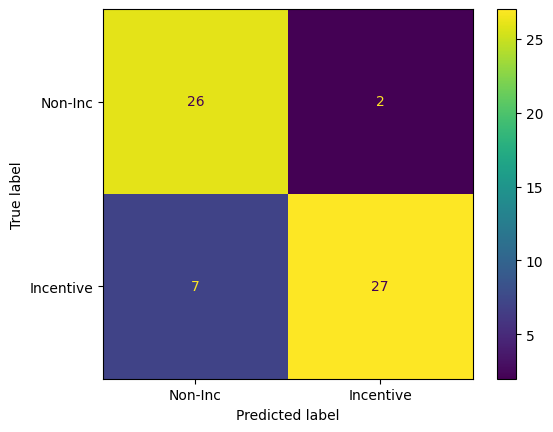

In [23]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(binlabsc, binlaba)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Inc", "Incentive"])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [24]:
mclabsc, mclaba = [], []
for i, labi in enumerate(binlabsc):
    if labi == "Incentive" and binlaba[i] == "Incentive":
        mclabsc.append(labelsc[i])
        mclaba.append(labelsa2[i])
print(len(mclabsc), len(mclaba))

26 26


In [25]:
cohen_kappa_score(mclabsc, mclaba)

0.9534883720930233

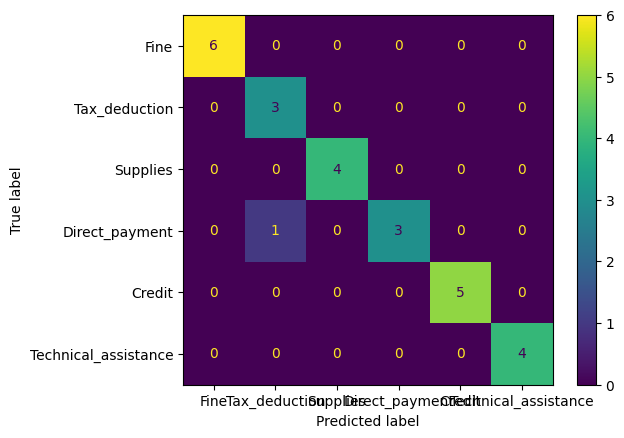

In [ ]:
confusion_matrix = metrics.confusion_matrix(mclabsc, mclaba)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## Pipeline Start

In [19]:
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
  dcno_json = json.load(f)
with open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:
  qry_json = json.load(f)

sents1, labels1 = dcno_to_sentlab(dcno_json)
#sents2, labels2 = remove_duplicates(group_duplicates(sents1,labels1,thresh=90))
sents3, labels3 = dcno_to_sentlab(qry_json)
sents3.extend(sents1)
labels3.extend(labels1)
sents4, labels4 = remove_duplicates(group_duplicates(sents3,labels3,thresh=90))


Sanity Check: 965 sentences and 965 labels
Sanity Check: 626 sentences and 626 labels
1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels


In [20]:
inc_sents1, noninc_sents1 = gen_bn_lists(sents4, labels4)
mc_sents1, mc_labels1 = gen_mc_sentlab(sents4, labels4)

Sanity Check: 263 incentive sentences and 1156 non-incentive sentences
Sanity Check: 263 incentive sentences and 263 incentive labels


In [ ]:
results_dict = {
    'bn':{
        'bert':{},
        'stella':{},
        'qwen':{}
    },
    'mc':{
        'bert':{},
        'stella':{},
        'qwen':{}
    }
}

stw = time.time()

cuda=True

for exp in range(10):
    st = time.time()
    real, pred = data_load_bn_bert(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict['bn']['bert'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_bn_stella(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict['bn']['stella'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_bn_qwen(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict['bn']['qwen'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_mc_bert(mc_sents1, mc_labels1, cuda, r_state=exp)
    results_dict['mc']['bert'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_mc_stella(mc_sents1, mc_labels1, cuda, r_state=exp)
    results_dict['mc']['stella'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_mc_qwen(mc_sents1, mc_labels1, cuda, r_state=exp)
    results_dict['mc']['qwen'][exp] = {'real':real, 'pred':pred}
    et = time.time()-st
    print(f"\n\nTime elapsed for experiment {exp}:", et//60, "min and", round(et%60), "sec")

etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")

In [ ]:
with open(output_dir+"/results_randp_xxx.json", 'w', encoding="utf-8") as outfile:
  json.dump(results_dict, outfile, ensure_ascii=False, indent=4)

## Section with unusable results method

In [30]:
#with open(output_dir+"/results_bert_stella_qwen_30Jan25.json", 'r', encoding="utf-8") as outfile:
#  results_dict = json.load(outfile)

In [31]:
'''
results_dict = {}

stw = time.time()

cuda=True

for exp in range(10):
    st = time.time()
    results_dict[f'bn_bert_{exp}'] = data_load_bn_bert(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict[f'bn_stella_{exp}'] = data_load_bn_stella(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict[f'bn_qwen_{exp}'] = data_load_bn_qwen(inc_sents1, noninc_sents1, cuda, r_state=exp)
    results_dict[f'mc_bert_{exp}'] = data_load_mc_bert(mc_sents1, mc_labels1, cuda, r_state=exp)
    results_dict[f'mc_stella_{exp}'] = data_load_mc_stella(mc_sents1, mc_labels1, cuda, r_state=exp)
    results_dict[f'mc_qwen_{exp}'] = data_load_mc_qwen(mc_sents1, mc_labels1, cuda, r_state=exp)
    et = time.time()-st
    print(f"\n\nTime elapsed for experiment {exp}:", et//60, "min and", round(et%60), "sec")

etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")
''' 

'\nresults_dict = {}\n\nstw = time.time()\n\ncuda=True\n\nfor exp in range(10):\n    st = time.time()\n    results_dict[f\'bn_bert_{exp}\'] = data_load_bn_bert(inc_sents1, noninc_sents1, cuda, r_state=exp)\n    results_dict[f\'bn_stella_{exp}\'] = data_load_bn_stella(inc_sents1, noninc_sents1, cuda, r_state=exp)\n    results_dict[f\'bn_qwen_{exp}\'] = data_load_bn_qwen(inc_sents1, noninc_sents1, cuda, r_state=exp)\n    results_dict[f\'mc_bert_{exp}\'] = data_load_mc_bert(mc_sents1, mc_labels1, cuda, r_state=exp)\n    results_dict[f\'mc_stella_{exp}\'] = data_load_mc_stella(mc_sents1, mc_labels1, cuda, r_state=exp)\n    results_dict[f\'mc_qwen_{exp}\'] = data_load_mc_qwen(mc_sents1, mc_labels1, cuda, r_state=exp)\n    et = time.time()-st\n    print(f"\n\nTime elapsed for experiment {exp}:", et//60, "min and", round(et%60), "sec")\n\netw = time.time()-stw\nprint("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")\n'

In [32]:
exp_res = {
    'bn':
    {
        'bert':
        {
            'f1':
            {
                "incentive": [],
                "non-incentive": []
            },
            'accuracy':[]
        },
        'stella':
        {
            'f1':            
            {
                "incentive": [],
                "non-incentive": []
            },
            'accuracy':[]
        },
        'qwen':
        {
            'f1':
            {
                "incentive": [],
                "non-incentive": []
            },
            'accuracy':[]
        }
    },
    'mc':
    {
        'bert':
        {
            'f1':
            {
                "Credit": [],
                "Direct_payment": [],
                "Fine": [],
                "Supplies": [],
                "Tax_deduction": [],
                "Technical_assistance": []
            },
            'accuracy':[]
        },
        'stella':
        {
            'f1':            
            {
                "Credit": [],
                "Direct_payment": [],
                "Fine": [],
                "Supplies": [],
                "Tax_deduction": [],
                "Technical_assistance": []
            },
            'accuracy':[]
        },
        'qwen':
        {
            'f1':
            {
                "Credit": [],
                "Direct_payment": [],
                "Fine": [],
                "Supplies": [],
                "Tax_deduction": [],
                "Technical_assistance": []
            },
            'accuracy':[]
        }
    }
}

lbl_dct = {
    'bn': ["incentive", "non-incentive"],
    'mc': ["Credit", "Direct_payment", "Fine","Supplies","Tax_deduction","Technical_assistance"]
}

In [33]:
for mode in list(results_dict):
    for model in list(results_dict[mode]):
        for exp in list(results_dict[mode][model]):
            for label in lbl_dct[mode]:
                exp_res[mode][model]['f1'][label].append(results_dict[mode][model][exp][label]['f1-score'])
            try:
                exp_res[mode][model]['accuracy'].append(results_dict[mode][model][exp]['accuracy'])
            except KeyError:
                exp_res[mode][model]['accuracy'].append(results_dict[mode][model][exp][])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2024533004.py, line 9)

In [ ]:
import numpy as np
for mode in list(exp_res):
    print(f'\n{mode}')
    for model in list(exp_res[mode]):
        print(f'\n{model}')
        for metric in list(exp_res[mode][model]):
            if metric == 'accuracy':
                print('Accuracy:', np.mean(exp_res[mode][model][metric]), 'avg, ', np.std(exp_res[mode][model][metric]), 'sd')
            else:
                print('F1-Scores:')
                for label in list(exp_res[mode][model][metric]):
                    print(f'{label}:', np.mean(exp_res[mode][model][metric][label]), 'avg, ', np.std(exp_res[mode][model][metric][label]), 'sd')

In [ ]:
'''
for experiment in list(results_dict):
    mode,model,i = experiment.split('_')
    for label in lbl_dct[mode]:
        try:
            results_dict[experiment][label]['f1-score']
        except Exception as e:
            print(e)
            print(experiment)
            print(list(results_dict[experiment]))
        exp_res[mode][model]['f1'][label].append(results_dict[experiment][label]['f1-score'])
    exp_res[mode][model]['accuracy'].append(results_dict[experiment]['accuracy'])
'''

'Tax_deduction'
mc_qwen_0
['Credit', 'Direct_payment', 'Fine', 'Supplies', 'Technical_assistance', 'accuracy', 'macro avg', 'weighted avg']


KeyError: 'Tax_deduction'

In [ ]:
import numpy as np

for model in list(exp_res['bn']):
    print(f'{model} accuracy:', round(np.mean(exp_res['bn'][model]['accuracy']),5))
    print(f'{model} sd:', round(np.std(exp_res['bn'][model]['accuracy']),5))

bert accuracy: 0.81103
bert sd: 0.0193
stella accuracy: 0.80969
stella sd: 0.01858
qwen accuracy: 0.80961
qwen sd: 0.01605


## Balancing the binary classification their way

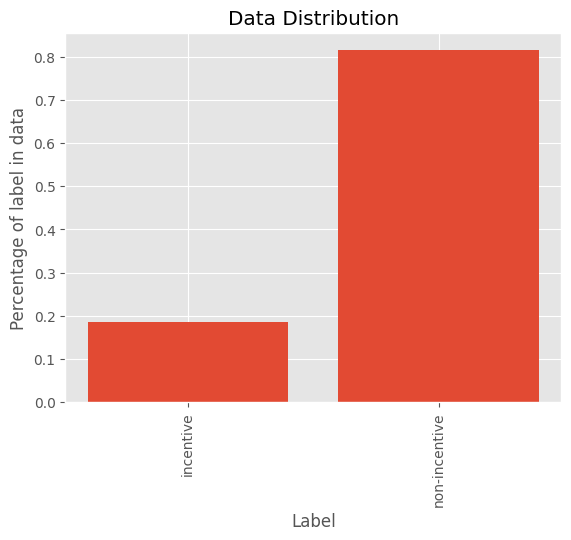

Label counts:
{'incentive': 0.18534178999295278, 'non-incentive': 0.8146582100070472}


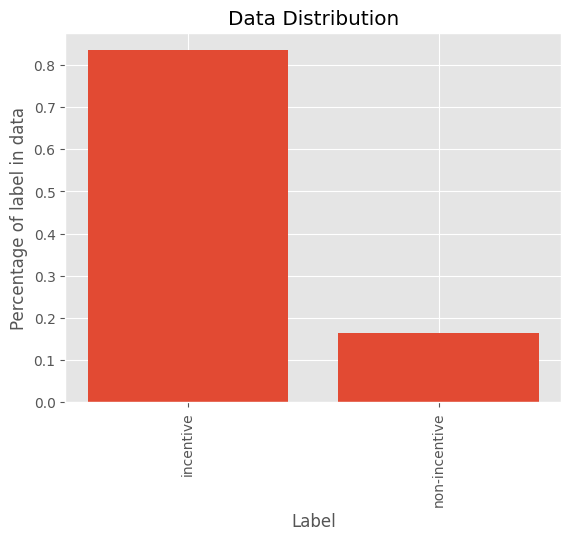

Label counts:
{'incentive': 0.834920634920635, 'non-incentive': 0.16507936507936508}


In [ ]:
#cuda = True
bnlbs = ["incentive"]*len(inc_sents1)
bnlbs.extend(["non-incentive"]*len(noninc_sents1))
nmbnlbs = labels2numeric(bnlbs, ["incentive", "non-incentive"])
plot_data_distribution(nmbnlbs, ["incentive", "non-incentive"])
#
nmrsinc = len(inc_sents1)
nmrsnoninc = int(nmrsinc*.2)
inc_sents2 = inc_sents1
noninc_sents2 = random.sample(noninc_sents1, nmrsnoninc)
#
rsbnlbs = ["incentive"]*len(inc_sents2)
rsbnlbs.extend(["non-incentive"]*len(noninc_sents2))
rsnmbnlbs = labels2numeric(rsbnlbs, ["incentive", "non-incentive"])
plot_data_distribution(rsnmbnlbs, ["incentive", "non-incentive"])

In [48]:
rs_results_dict = {
    'bn':{
        'bert':{},
        'stella':{},
        'qwen':{}
    }
}

stw = time.time()

cuda=True

for exp in range(10):
    st = time.time()
    real, pred = data_load_bn_bert(inc_sents2, noninc_sents2, cuda, r_state=exp)
    rs_results_dict['bn']['bert'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_bn_stella(inc_sents2, noninc_sents2, cuda, r_state=exp)
    rs_results_dict['bn']['stella'][exp] = {'real':real, 'pred':pred}
    real, pred = data_load_bn_qwen(inc_sents2, noninc_sents2, cuda, r_state=exp)
    rs_results_dict['bn']['qwen'][exp] = {'real':real, 'pred':pred}

with open(output_dir+"/results_rs_bn_randp_13Feb25.json", 'w', encoding="utf-8") as outfile:
  json.dump(rs_results_dict, outfile, ensure_ascii=False, indent=4)

Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 69.82it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 78.16it/s]


Evaluating.
Loading model.


modules.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\allie\.cache\huggingface\hub\models--dunzhang--stella_en_1.5B_v5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/169k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

2_Dense_1024%2Fconfig.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.57it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 23.26it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 22.65it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 22.37it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 81.47it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 80.50it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.36it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 23.01it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 22.44it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 21.52it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 76.91it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 66.56it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.01it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 24.13it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 22.19it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 22.75it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 65.71it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 64.21it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.10it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 22.90it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 22.98it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 22.51it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 73.62it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 76.47it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 21.88it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 21.03it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 20.47it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 20.62it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 65.65it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 72.31it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 21.83it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 20.29it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 20.69it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 19.80it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:04<00:00, 61.29it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:00<00:00, 63.73it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:11<00:00, 21.88it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 20.79it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 20.30it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 16.90it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:03<00:00, 65.50it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:01<00:00, 58.97it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 20.29it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 19.33it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 20.50it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 19.40it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:04<00:00, 62.77it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:01<00:00, 57.65it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:12<00:00, 19.72it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 21.05it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:13<00:00, 18.71it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:03<00:00, 16.39it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:39<00:00,  6.38it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:09<00:00,  6.37it/s]


Evaluating.
Loading model.
Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.60it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 23.95it/s]


Evaluating.
Loading model.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding training sentences.


100%|██████████| 252/252 [00:10<00:00, 23.06it/s]


Encoding test sentences.


100%|██████████| 63/63 [00:02<00:00, 23.53it/s]


Evaluating.


## FBQVDO evaluation
(confusion matrices and F1 scores, and accuracy)

In [54]:
with open(output_dir+"/results_randp_30Jan25.json", 'r', encoding="utf-8") as outfile:
#with open(output_dir+"/results_rs_bn_randp_13Feb25.json", 'r', encoding="utf-8") as outfile:
  rp_labels = json.load(outfile)

### basic confusion matrices

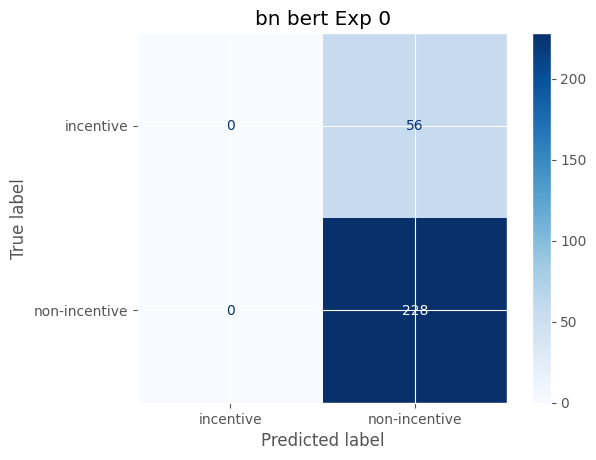

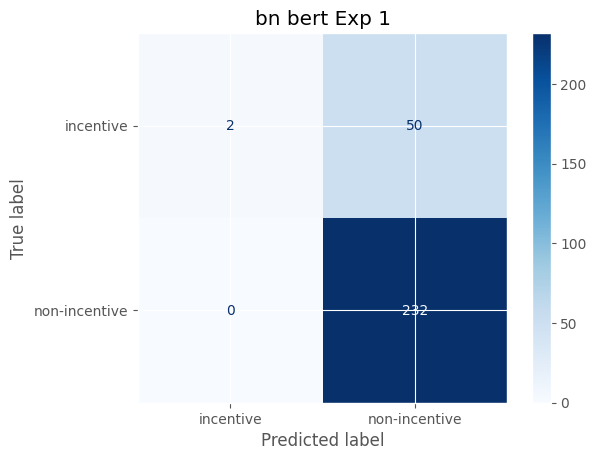

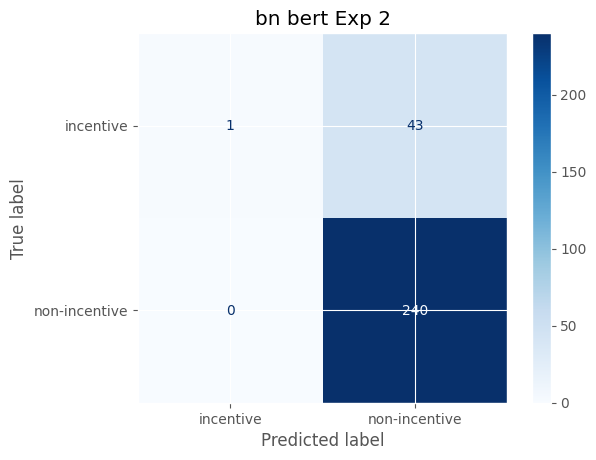

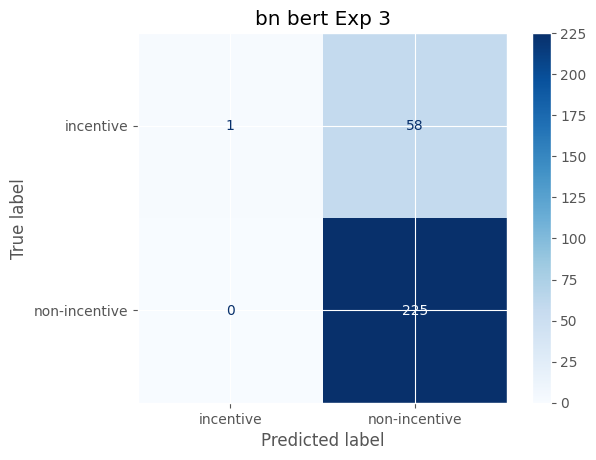

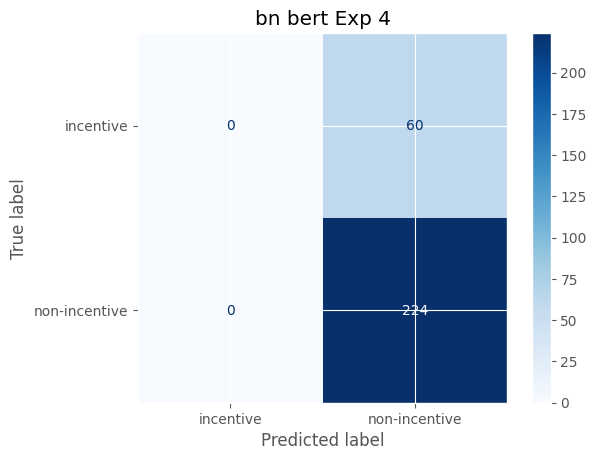

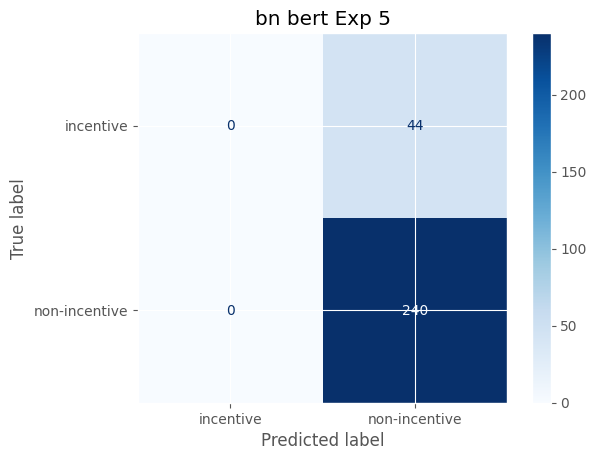

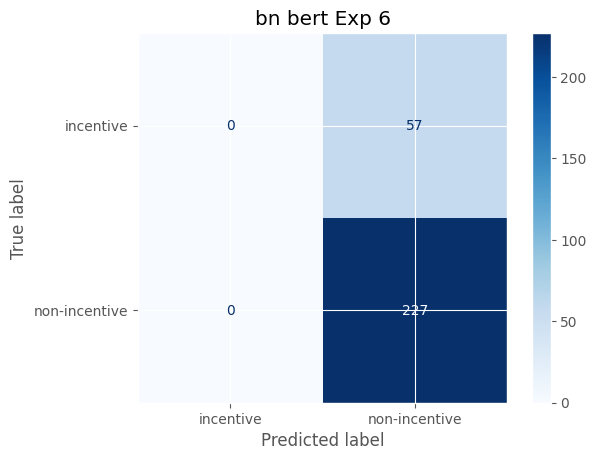

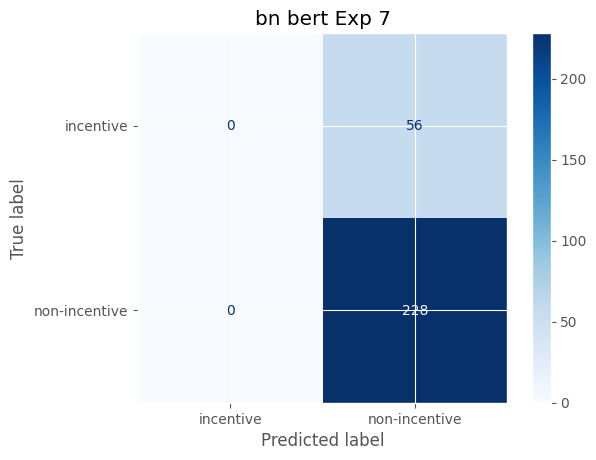

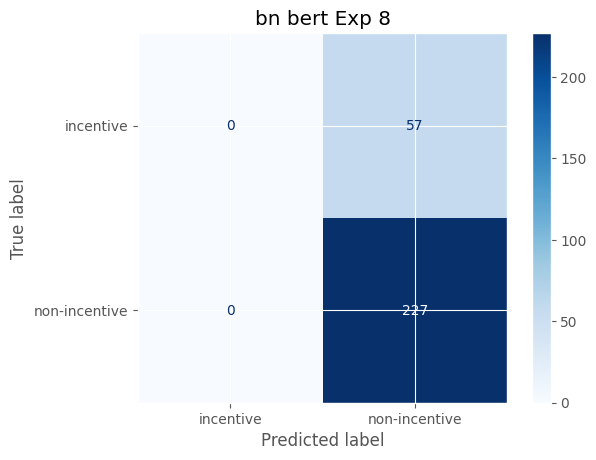

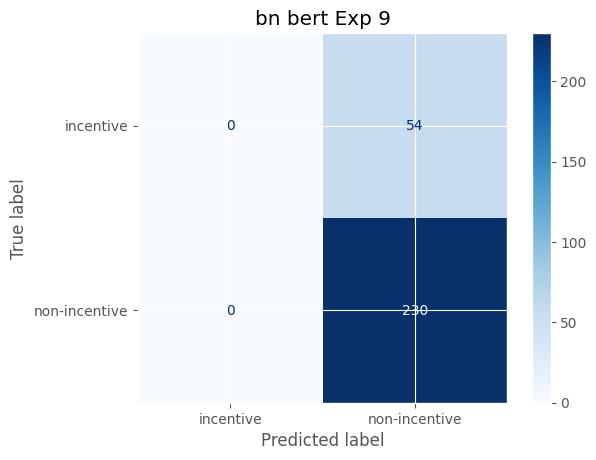

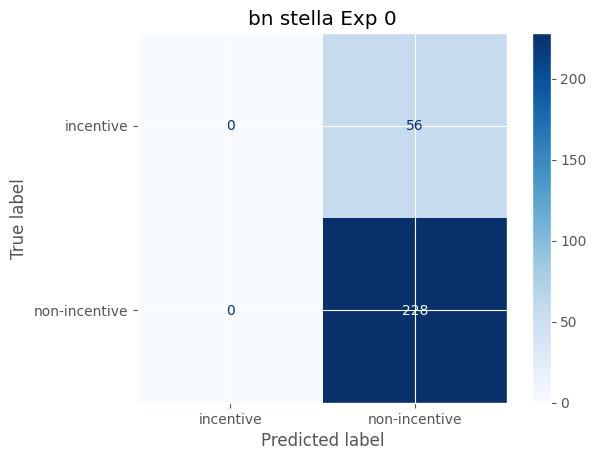

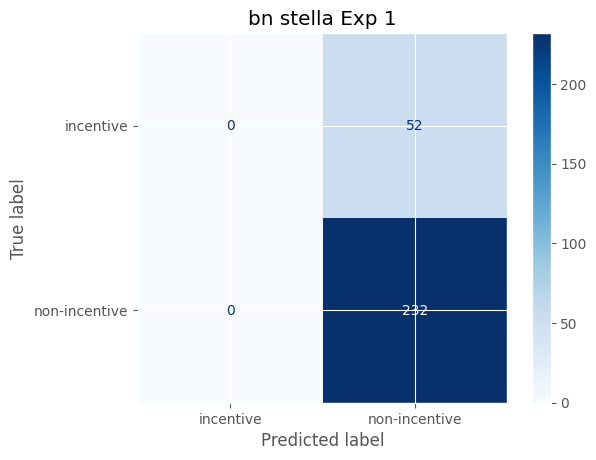

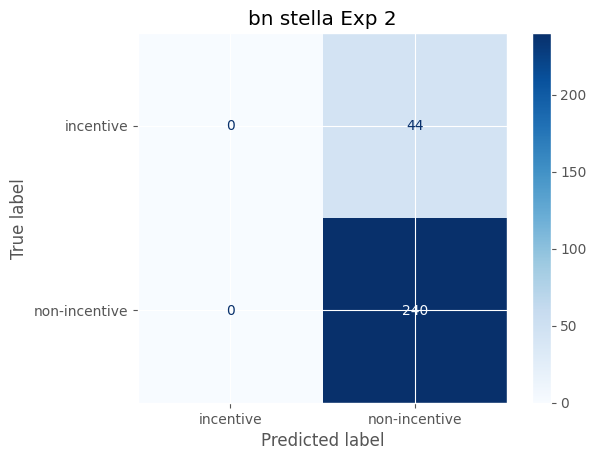

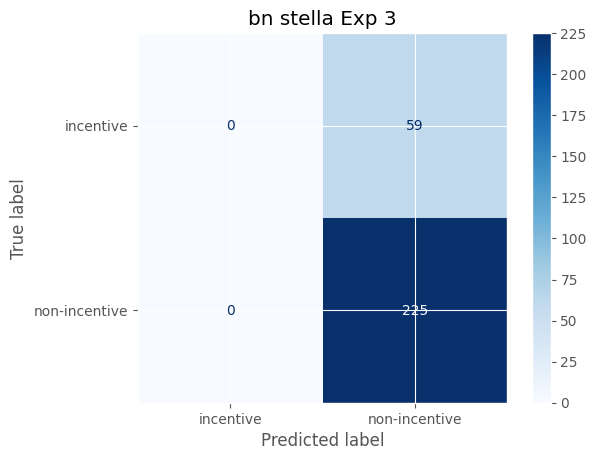

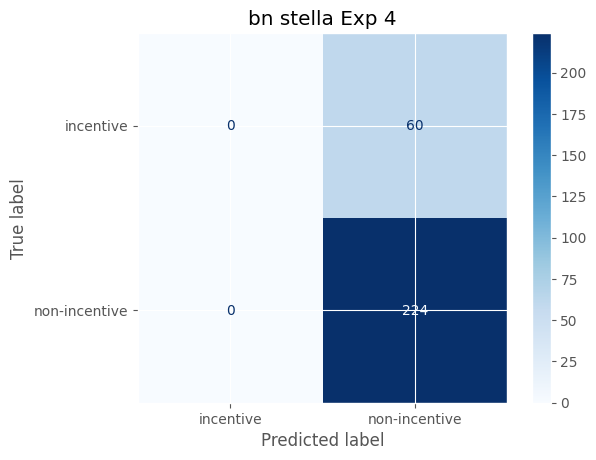

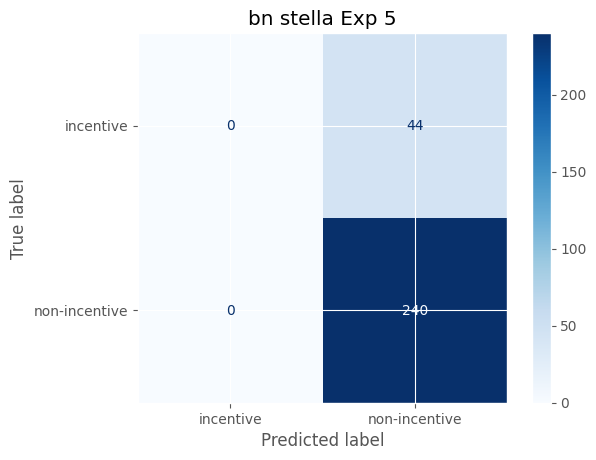

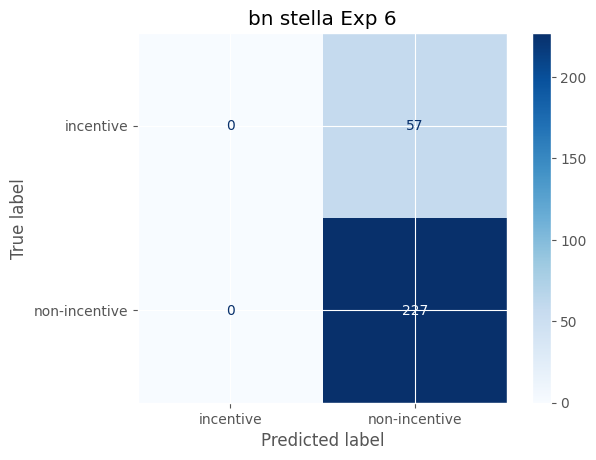

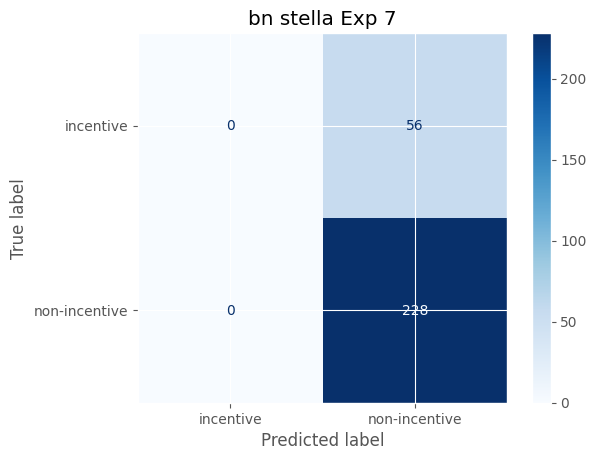

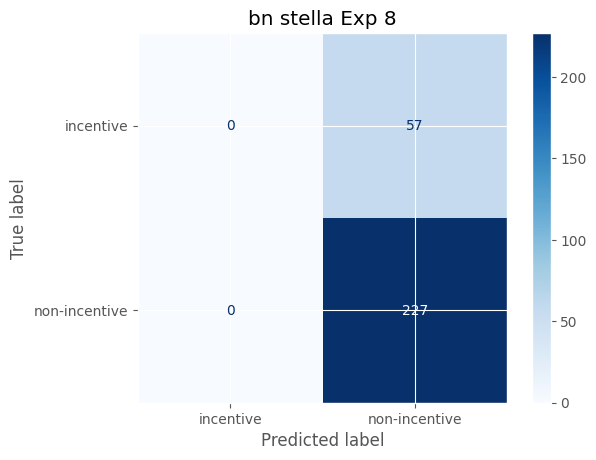

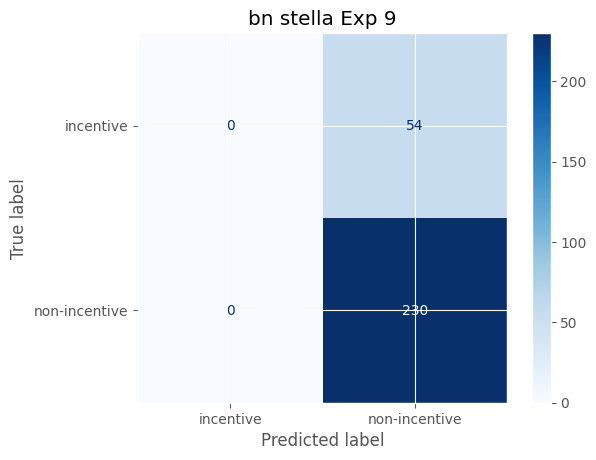

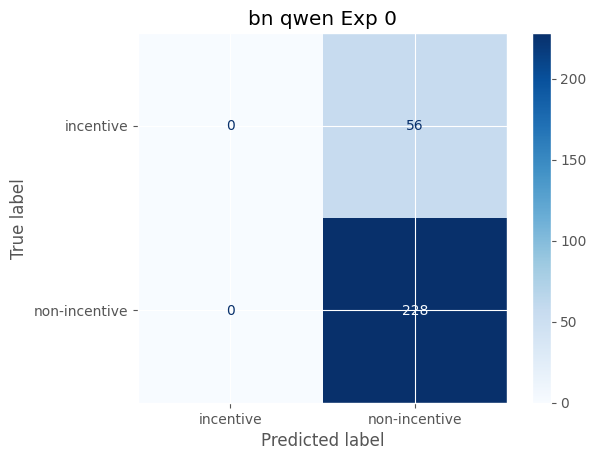

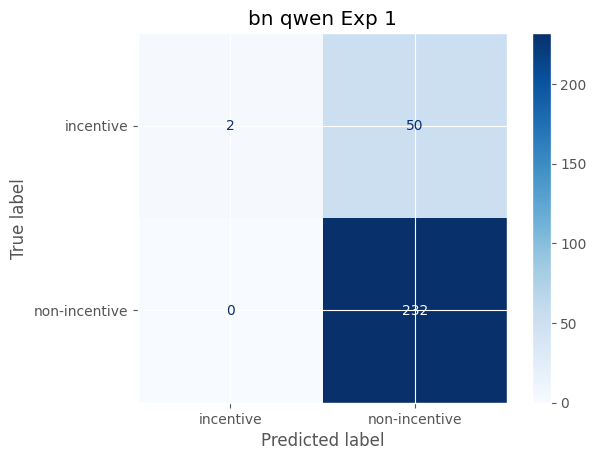

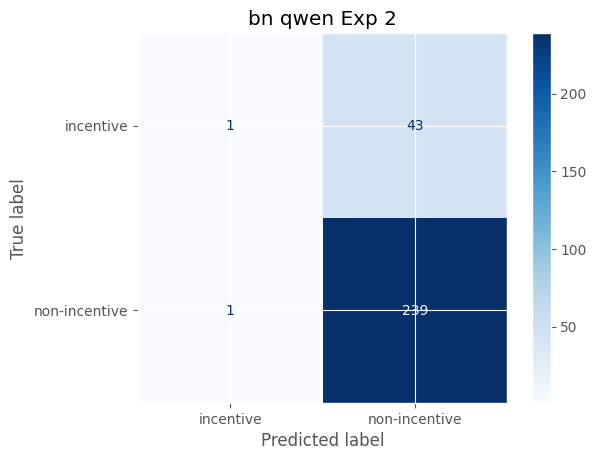

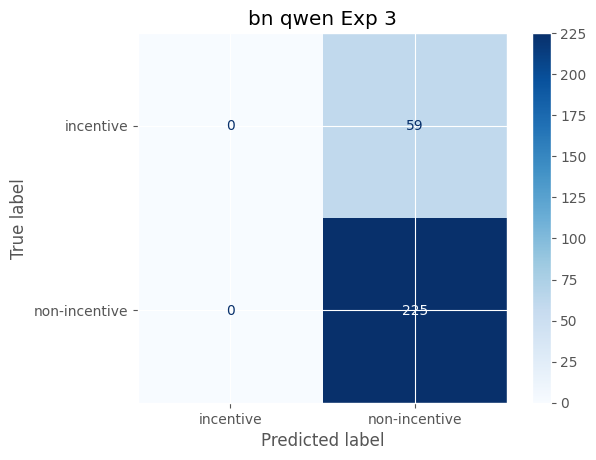

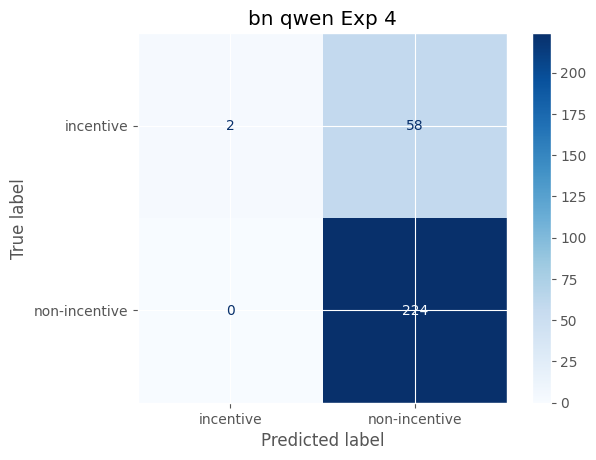

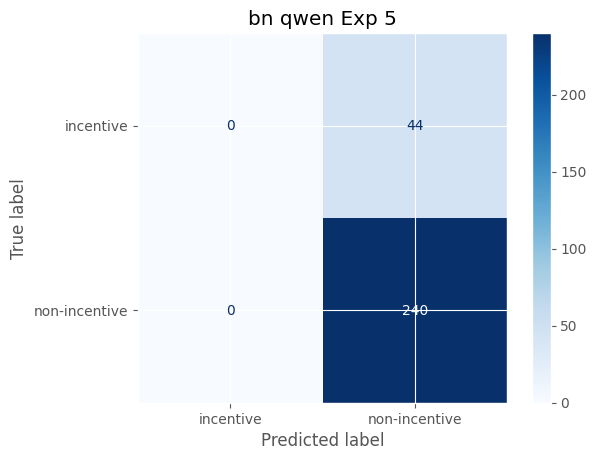

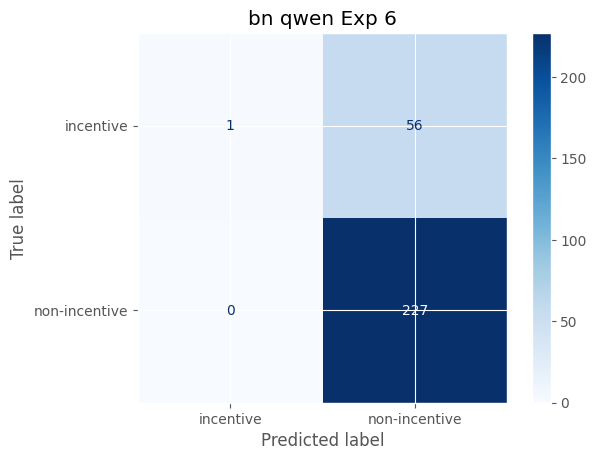

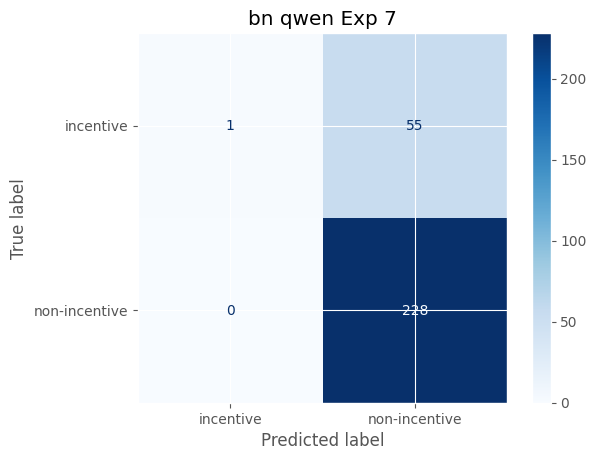

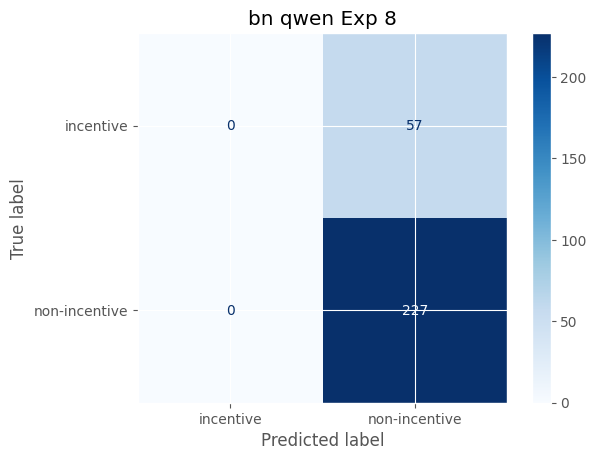

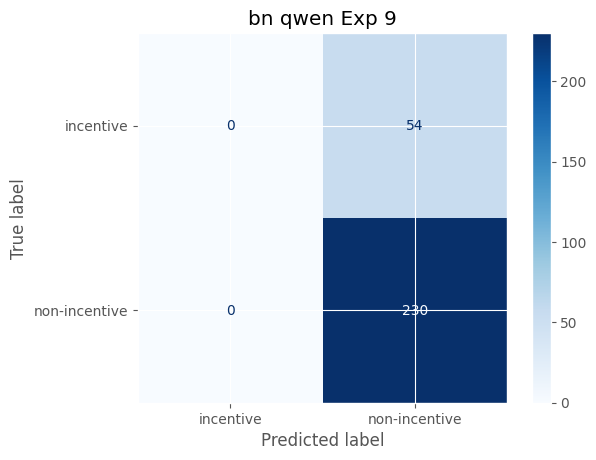

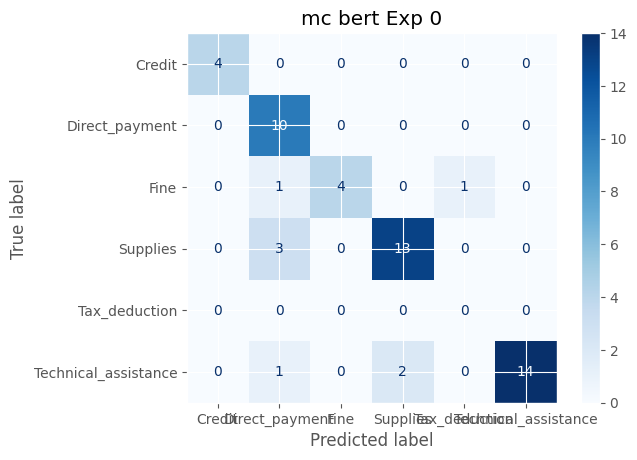

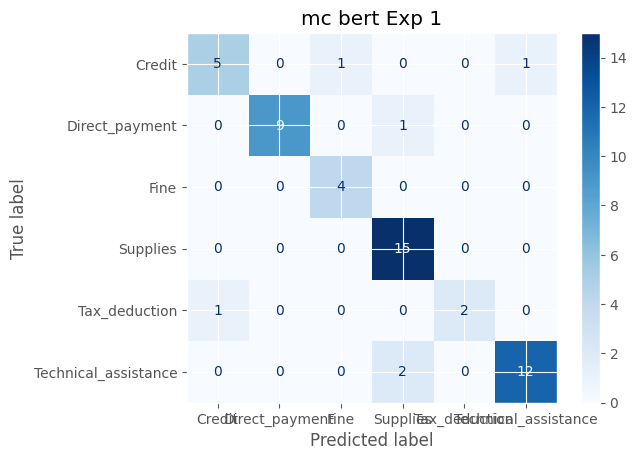

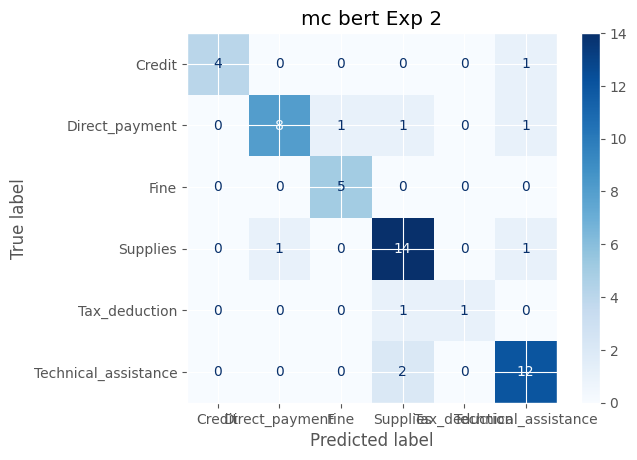

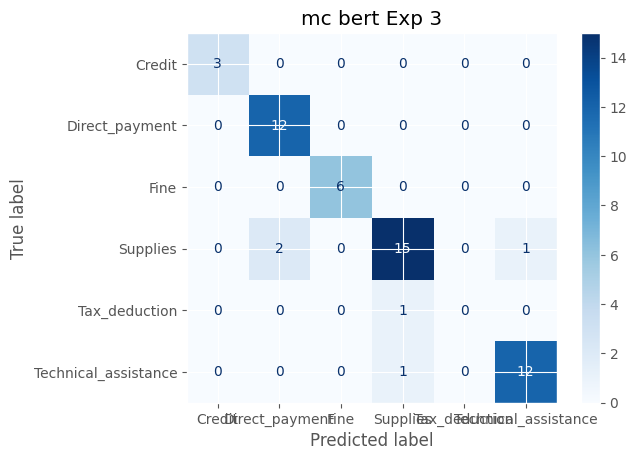

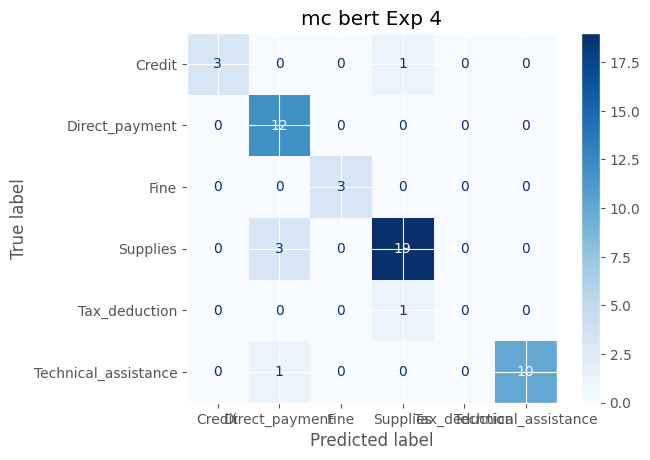

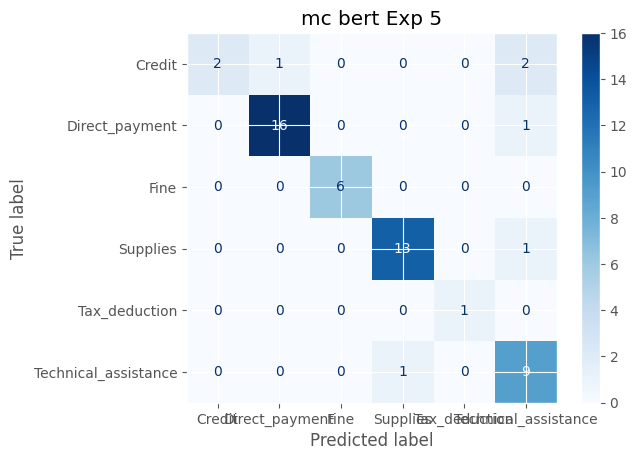

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (6).

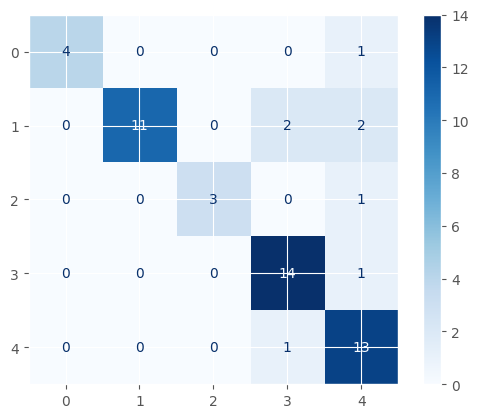

In [56]:
from sklearn import metrics
for cls in list(rp_labels):
    for model in list(rp_labels[cls]):
        for exp in list(rp_labels[cls][model]):
            real = rp_labels[cls][model][exp]["real"]
            pred = rp_labels[cls][model][exp]["pred"]
            confusion_matrix = metrics.confusion_matrix(real, pred)
            cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=lbl_dct[cls])
            cm_display.plot(cmap=plt.cm.Blues)
            plt.title(f'{cls} {model} Exp {exp}')
            plt.show()

### ModelEvaluator

In [55]:
lbl_dct = {
    'bn': ["incentive", "non-incentive"],
    'mc': ["Credit", "Direct_payment", "Fine","Supplies","Tax_deduction","Technical_assistance"]
}

for cls in list(rp_labels):
    for model in list(rp_labels[cls]):
        for exp in list(rp_labels[cls][model]):
            #try:
            numeric_real_labels = labels2numeric(rp_labels[cls][model][exp]['real'], lbl_dct[cls])
            #plot_data_distribution(numeric_train_labels, lbl_dct[cls])
            numeric_pred_labels = labels2numeric(rp_labels[cls][model][exp]['pred'], lbl_dct[cls])
            #evaluator = ModelEvaluator(lbl_dct[cls], y_true=numeric_real_labels, y_pred=numeric_pred_labels)
            #evaluator.plot_confusion_matrix(color_map='Blues')
            rpt = classification_report(rp_labels[cls][model][exp]['real'], rp_labels[cls][model][exp]['pred'], zero_division=1)
            print(f'\n{cls}{model}{exp}')
            print(rpt)
            #except Exception as e:
            #    print(f'{cls}{model}{exp}: {e}')



bnbert0
               precision    recall  f1-score   support

    incentive       1.00      0.00      0.00        56
non-incentive       0.80      1.00      0.89       228

     accuracy                           0.80       284
    macro avg       0.90      0.50      0.45       284
 weighted avg       0.84      0.80      0.72       284


bnbert1
               precision    recall  f1-score   support

    incentive       1.00      0.04      0.07        52
non-incentive       0.82      1.00      0.90       232

     accuracy                           0.82       284
    macro avg       0.91      0.52      0.49       284
 weighted avg       0.86      0.82      0.75       284


bnbert2
               precision    recall  f1-score   support

    incentive       1.00      0.02      0.04        44
non-incentive       0.85      1.00      0.92       240

     accuracy                           0.85       284
    macro avg       0.92      0.51      0.48       284
 weighted avg       0.87      